

# RNN for Time Series

RNNs are used for sequence modeling. This tutorial will look at a time series data to be modeled and predicted using RNNs. 

In [2]:
#
# Import Libraries
#
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split

#


#

## Data

We will use retail data for time-series modeling. 

Link to the dataset:
 https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at:
https://www.census.gov/retail/marts/about_the_surveys.html

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted
Frequency:  Monthly

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

### Read data first -  Use index_col = 'DATE' and 'parse_dates = True' as a parameter.

In [3]:
# Your code to read data

df=pd.read_csv('MRTSSM448USN.csv', index_col='DATE', parse_dates=True)

# Print first few rows of data
df.head()

,MRTSSM448USN
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


Does the sales column has any name?

If no, set the name of the colum as 'Sales'.

In [4]:
# Set name of column as 'Sales'. Use - df.columns 

df.columns = ['Sales']
df.head()

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


Plot your data - Year vs Sales

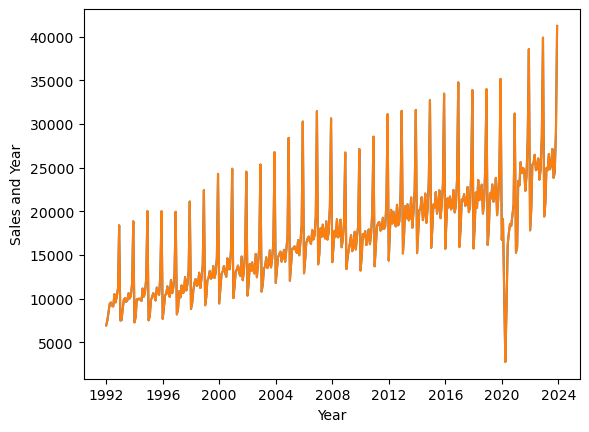

In [5]:
# Your code to plot Year vs Sales. Use either matplot library of pandas dataframe.

plt.plot(df['Sales'], label='Year')
plt.plot(df['Sales'], label = 'Sales')
plt.xlabel('Year')
plt.ylabel('Sales and Year')

plt.show()



### Next we will do Train Test Split. 

We will use last 1.5 year (18 month) samples for testing. Rest is for training.

In [6]:
# Assign variable test size = 18
test_size = 18

# Store length of data in variable length.
data_length = len(df)
data_length
# store training size in varialable train_size (Remember training size = total size - test_size)
train_size = data_length- test_size
train_size

366

Now, we will find the indexes of the test data. Remember, these are the last 18 indexes in the pandas dataframe.

In [7]:
#Assign the start of test index in data frame to variable test_index.  Remember, it is equal to the length of dataframe - test size
len(df)- 18


366

Next, we will separate train and test datasets.

In [8]:
# Store all data from 0 to test_index in variable train. Hint - Use df.iloc.
test_index = train_size
train = df.iloc[:test_index]

# Store everthing from test_index to the last sample in test variable. Hint - Use df.iloc.
test = df.iloc[test_index:]


In [9]:
# Print the size of the train data
# Print the size of the test data
# Print the train data
# Print the test data
print(train.size)
print(test.size)
print(train)
print(test)


366
18
              Sales
DATE               
1992-01-01   6938.0
1992-02-01   7524.0
1992-03-01   8475.0
1992-04-01   9401.0
1992-05-01   9558.0
...             ...
2022-02-01  20152.0
2022-03-01  25347.0
2022-04-01  25539.0
2022-05-01  26470.0
2022-06-01  24701.0

[366 rows x 1 columns]
              Sales
DATE               
2022-07-01  24904.0
2022-08-01  26049.0
2022-09-01  23629.0
2022-10-01  24787.0
2022-11-01  28645.0
2022-12-01  39883.0
2023-01-01  19405.0
2023-02-01  20937.0
2023-03-01  24963.0
2023-04-01  24700.0
2023-05-01  26557.0
2023-06-01  24809.0
2023-07-01  25364.0
2023-08-01  27143.0
2023-09-01  23840.0
2023-10-01  24438.0
2023-11-01  29150.0
2023-12-01  41228.0


### In Neural Networks, we need to Scale Data between 0-1

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
#
# Check if the data has been scaled properly
print(scaled_train.min())
print(scaled_train.max())
print(scaled_test.min())
print(scaled_test.max())


#

0.0
1.0
0.4650117279124316
1.0743884731374957


# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

# We will use 12 months as input and then predict the next month out


In [13]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [14]:
X, y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.11688819 0.13325142 0.15980677 0.18566402 0.19004803 0.17954875
 0.17734279 0.21671507 0.19046688 0.20948285 0.23553557 0.43680889]
Predict this y: 
 [[0.1326371]]


### Create the Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN, Dropout
from tensorflow.keras.layers import GRU

import tensorflow as tf

In [16]:
# We're only using one feature in our time series
n_features = 1

# Define your own models. 

Use 1. SimpleRNN, LSTM, or GRU neural network.

APIs:
https://keras.io/api/layers/recurrent_layers/

In [17]:
model = Sequential([
    SimpleRNN(64, input_shape=(12, 1), return_sequences=True),  # Simple RNN layer with 64 units and return sequences
    Dropout(0.2),                                               # Dropout layer to prevent overfitting
    LSTM(32),                                                   # LSTM layer with 32 units
    Dropout(0.2),                                               # Dropout layer
    Dense(16, activation='relu'),                               # Dense layer with ReLU activation
    Dense(1)                                                    # Output layer
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 12, 64)            4224      
                                                                 
 dropout (Dropout)           (None, 12, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 17185 (67.13 KB)
Trainable params: 17185 (

In [19]:
model.compile(optimizer='adam', loss='mse')



### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [20]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

# Your code to create an object early-stop.
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Now, fit your model.

In [22]:
history =  model.fit(generator,  epochs=30,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/30

354/354 [==============================] - 16s 21ms/step - loss: 0.0234 - val_loss: 0.0459
Epoch 2/30
354/354 [==============================] - 5s 15ms/step - loss: 0.0134 - val_loss: 0.0507
Epoch 3/30
354/354 [==============================] - 6s 16ms/step - loss: 0.0077 - val_loss: 0.0182
Epoch 4/30
354/354 [==============================] - 6s 16ms/step - loss: 0.0065 - val_loss: 0.0098
Epoch 5/30
354/354 [==============================] - 6s 16ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 6/30
354/354 [==============================] - 6s 17ms/step - loss: 0.0054 - val_loss: 0.0107
Epoch 7/30
354/354 [==============================] - 6s 16ms/step - loss: 0.0062 - val_loss: 0.0478
Epoch 8/30
354/354 [==============================] - 6s 17ms/step - loss: 0.0064 - val_loss: 0.0081


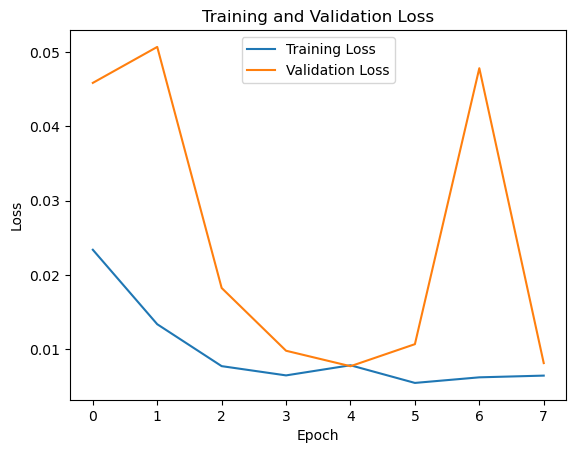

In [23]:
# Get Losses from dataframe (hint - model.history.history)- See previous week tutorial.
train_losses = history.history['loss']
val_losses = history.history['val_loss']
# Plot losses in the dataframe.


# Plot losses in the dataframe
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

C:\Users\aashi\AppData\Local\Temp\ipykernel_19008\890740826.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


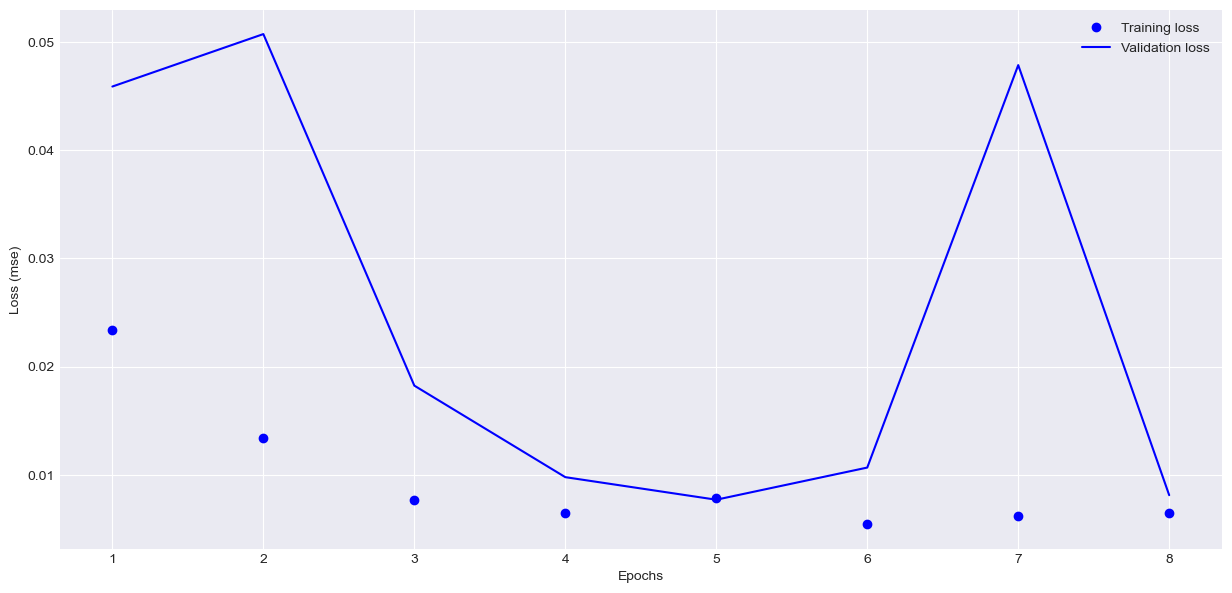

In [39]:
# printing Loss for the neural network training process

history_dict = history.history
plt.style.use('seaborn-darkgrid')

acc_values = history_dict['loss']
val_acc_values = history_dict['val_loss']
epochs = range(1, len(acc_values) + 1)

plt.figure(num=1, figsize=(15,7))
plt.plot(epochs, acc_values, 'bo', label='Training loss')
plt.plot(epochs, val_acc_values, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.legend()

plt.show()

## Evaluate on Test Data

In [40]:
first_eval_batch = scaled_train[-length:]

In [41]:
n_input = 12
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)


1/1 [==============================] - 0s 54ms/step


array([[0.6176675]], dtype=float32)

In [42]:
# compare with the true result:
scaled_test[0]

array([0.61856361])

#### Try predicting the series!

In [46]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))


for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for 
    # grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    print(current_batch)


1/1 [==============================] - 0s 56ms/step
[[[0.6153524 ]
  [0.54716296]
  [0.59505194]
  [0.7145091 ]
  [1.        ]
  [0.42066905]
  [0.48587066]
  [0.63093377]
  [0.6362951 ]
  [0.66229197]
  [0.61289512]
  [0.6176675 ]]]
1/1 [==============================] - 0s 50ms/step
[[[0.54716296]
  [0.59505194]
  [0.7145091 ]
  [1.        ]
  [0.42066905]
  [0.48587066]
  [0.63093377]
  [0.6362951 ]
  [0.66229197]
  [0.61289512]
  [0.6176675 ]
  [0.63052201]]]
1/1 [==============================] - 0s 59ms/step
[[[0.59505194]
  [0.7145091 ]
  [1.        ]
  [0.42066905]
  [0.48587066]
  [0.63093377]
  [0.6362951 ]
  [0.66229197]
  [0.61289512]
  [0.6176675 ]
  [0.63052201]
  [0.55865318]]]
1/1 [==============================] - 0s 53ms/step
[[[0.7145091 ]
  [1.        ]
  [0.42066905]
  [0.48587066]
  [0.63093377]
  [0.6362951 ]
  [0.66229197]
  [0.61289512]
  [0.6176675 ]
  [0.63052201]
  [0.55865318]
  [0.58218515]]]
1/1 [==============================] - 0s 56ms/step
[[[1.       

## Inverse Transformations and Compare

In [44]:
true_predictions = scaler.inverse_transform(test_predictions)

In [29]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\aashi\AppData\Local\Temp\ipykernel_19008\1339453577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


# Check and plot predictions

In [47]:
# Print the test variable.
test

,Sales,Predictions
DATE,,
2022-07-01,24904.0,24871.908374
2022-08-01,26049.0,25332.254319
2022-09-01,23629.0,22758.487533
2022-10-01,24787.0,23601.214563
2022-11-01,28645.0,26280.040199
2022-12-01,39883.0,33526.944929
2023-01-01,19405.0,21136.833383
2023-02-01,20937.0,22175.641236
2023-03-01,24963.0,25245.580448


<Axes: xlabel='DATE'>

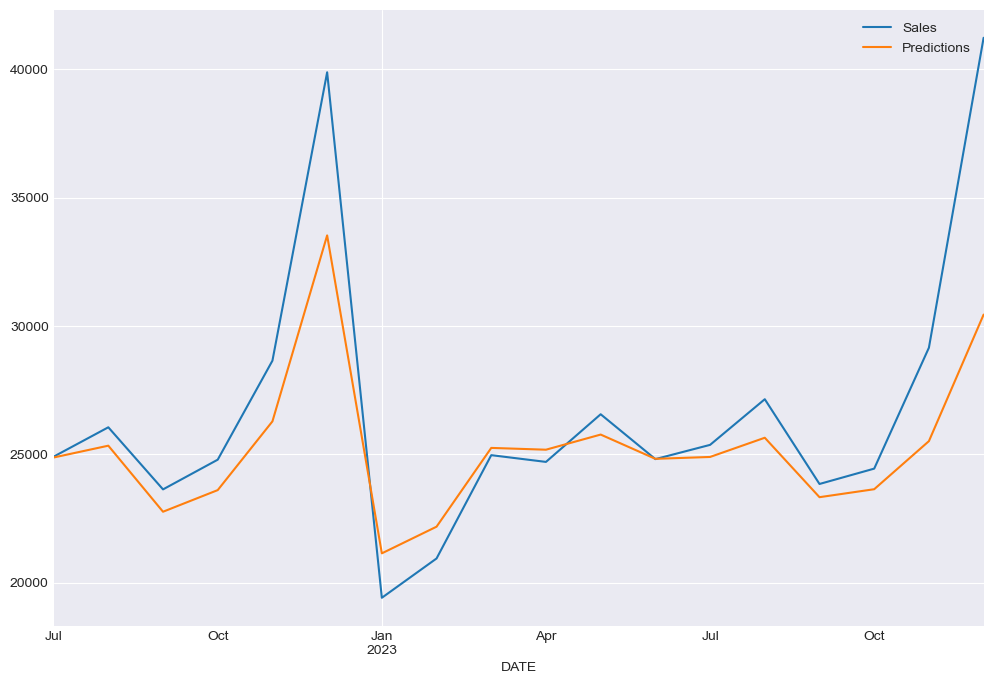

In [48]:
# Your code to plot actual sales and predictions.
test.plot(figsize=(12,8))

# Retrain and Forecasting

In [32]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [33]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, 
                                scaled_full_data, length=length, batch_size=1)

In [51]:
#
# Use any neural network model based on RNN
#
# Create the model
model = Sequential([
    SimpleRNN(64, input_shape=(12, 1), return_sequences=True),  # Simple RNN layer with 64 units and return sequences
    Dropout(0.2),                                               # Dropout layer to prevent overfitting
    LSTM(32),                                                   # LSTM layer with 32 units
    Dropout(0.2),                                               # Dropout layer
    Dense(16, activation='relu'),                               # Dense layer with ReLU activation
    Dense(1)                                                    # Output layer
])

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 12, 64)            4224      
                                                                 
 dropout_2 (Dropout)         (None, 12, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 17185 (67.13 KB)
Trainable params: 17185

In [53]:
# compile the model
model.compile(optimizer='adam', loss='mse')

In [54]:
# use early_stop
early_stop = EarlyStopping(monitor='loss',patience=5)

In [56]:
# fit the model
history_2 =  model.fit(generator, epochs=30, callbacks=[early_stop])

Epoch 1/30
372/372 [==============================] - 18s 17ms/step - loss: 0.0188
Epoch 2/30
372/372 [==============================] - 6s 16ms/step - loss: 0.0110
Epoch 3/30
372/372 [==============================] - 6s 17ms/step - loss: 0.0078
Epoch 4/30
372/372 [==============================] - 6s 16ms/step - loss: 0.0069
Epoch 5/30
372/372 [==============================] - 6s 16ms/step - loss: 0.0051
Epoch 6/30
372/372 [==============================] - 6s 16ms/step - loss: 0.0056
Epoch 7/30
372/372 [==============================] - 6s 16ms/step - loss: 0.0048
Epoch 8/30
372/372 [==============================] - 6s 15ms/step - loss: 0.0051
Epoch 9/30
372/372 [==============================] - 6s 16ms/step - loss: 0.0057
Epoch 10/30
372/372 [==============================] - 6s 15ms/step - loss: 0.0049
Epoch 11/30
372/372 [==============================] - 6s 15ms/step - loss: 0.0044
Epoch 12/30
372/372 [==============================] - 6s 16ms/step - loss: 0.0045
Epoch 13/30


In [59]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for  grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction forecast.append(current_pred)
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
     
    
 


1/1 [==============================] - 0s 51ms/step


In [60]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [61]:
df

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0
...,...
2023-08-01,27143.0
2023-09-01,23840.0
2023-10-01,24438.0


In [62]:
forecast_index = pd.date_range(start='2024-01-01',periods=periods,freq='MS')

In [63]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [64]:
forecast_df

,Forecast
2024-01-01,21941.776539
2024-02-01,22201.104420
2024-03-01,24847.935113
2024-04-01,24579.819242
2024-05-01,26787.948444
2024-06-01,24497.461454
2024-07-01,26179.775574
2024-08-01,30907.694905
2024-09-01,23499.346883
2024-10-01,24908.923806


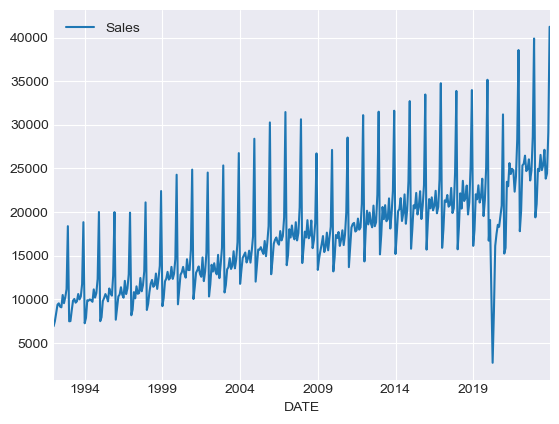

In [66]:
# Plot sales - Values in dataframe
df.plot();

<Axes: >

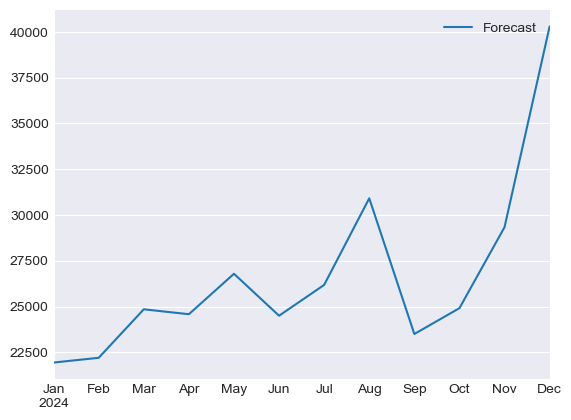

In [67]:
# Plot forecast - Values in forecast_df
forecast_df.plot()

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

<Axes: xlabel='DATE'>

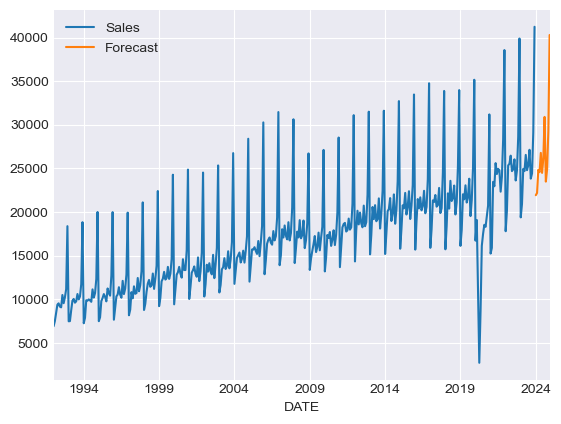

In [68]:
ax = df.plot()
forecast_df.plot(ax=ax)

(624.0, 660.0)

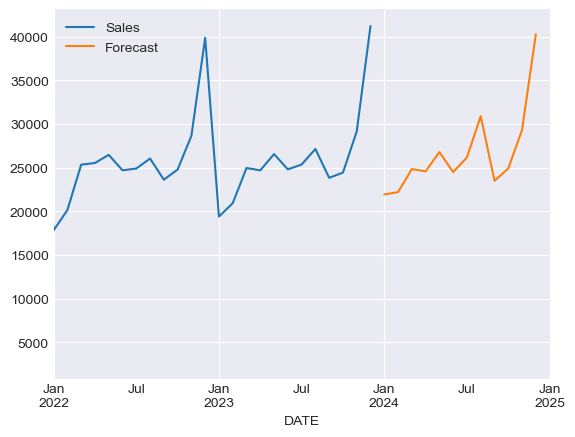

In [69]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2022-01-01','2025-01-01')

# Try the same example with a LSTM and GRU! 
Hint: Use LSTM instead of SimpleRNN!